## Income Risks Estimation 

This notebook draws from the integrated moving average (IMA) process class to estimate the income risks using PSID data (annual/biennial) and SIPP panel (monthly).

In [55]:
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
import pandas as pd
import copy as cp

In [56]:
## figure plotting configurations

plt.style.use('seaborn')
plt.rcParams["font.family"] = "Times New Roman" #'serif'
plt.rcParams['font.serif'] = 'Ubuntu'
plt.rcParams['font.monospace'] = 'Ubuntu Mono'
plt.rcParams['axes.labelweight'] = 'bold'

## Set the 
plt.rc('font', size=25)
# Set the axes title font size
plt.rc('axes', titlesize=20)
# Set the axes labels font size
plt.rc('axes', labelsize=20)
# Set the font size for x tick labels
plt.rc('xtick', labelsize=20)
# Set the font size for y tick labels
plt.rc('ytick', labelsize=20)
# Set the legend font size
plt.rc('legend', fontsize=20)
# Set the font size of the figure title
plt.rc('figure', titlesize=20)

In [57]:
from IncomeProcess import IMAProcess as ima

In [58]:
## creating an instance used for data estimation 

t = 10
ma_nosa = np.array([1])  ## ma coefficient without serial correlation
p_sigmas = np.random.uniform(0,1,t) ## allowing for time-variant shocks 
pt_ratio = 0.33
t_sigmas = pt_ratio * p_sigmas # sizes of the time-varying permanent volatility
sigmas = np.array([p_sigmas,
                   t_sigmas])

dt = ima(t = t,
         ma_coeffs = ma_nosa)
dt.sigmas = sigmas

In [59]:
### define the general function

def estimate_sample(sample):
    """
    this function take a sample of the first differences of income in different periods (column) of all individuals (row)
    and returns the estimates of the potentially time-varying permanent and transitory sigmas. 
    """
    data = np.array(sample)
    data_mean = np.nanmean(data,axis=0)
    data_var = ma.cov(ma.masked_invalid(data), rowvar=False)
    moms_data = {'Mean':data_mean,
                 'Var':data_var}
    ## initialize 
    dt_data_est = cp.deepcopy(dt)
    t_data = len(data_var)+1
    dt_data_est.t = t_data
    dt_data_est.GetDataMoments(moms_data)
    para_guess_this = np.ones(2*t_data + dt_data_est.ma_q)
    
    ## estimation
    data_para_est = dt_data_est.EstimatePara(method='BFGS',
                               para_guess = para_guess_this)
    
    return data_para_est

### Estimation using SIPP data (yearly)

In [60]:
## SIPP data 
SIPP_Y = pd.read_stata('../../../SIPP/sipp_matrix_Y.dta',
                    convert_categoricals=False)   
SIPP_Y.index = SIPP_Y['uniqueid']
SIPP_Y = SIPP_Y.drop(['uniqueid'], axis=1)
SIPP_Y = SIPP_Y.dropna(axis=0,how='all')

In [61]:
## different samples 

education_groups = [1, #'HS dropout',
                   2, # 'HS graduate',
                   3] #'college graduates/above'
gender_groups = [1, #'male',
                2] #'female'

#byear_groups = list(np.array(SIPP.byear_5yr.unique(),dtype='int32'))

age_groups = list(np.array(SIPP_Y.age_5yr.unique(),dtype='int32'))

group_by = ['educ','gender','age_5yr']
all_drop = group_by #+['age_h','byear_5yr']

## full sample 
sample_full =  SIPP_Y.drop(all_drop,axis=1)

## sub sample 
sub_samples = []
para_est_list = []
sub_group_names = []

for edu in education_groups:
    for gender in gender_groups:
        for age5 in age_groups:
            belong = (SIPP_Y['educ']==edu) & (SIPP_Y['gender']==gender) & (SIPP_Y['age_5yr']==age5)
            obs = np.sum(belong)
            #print(obs)
            if obs > 1:
                sample = SIPP_Y.loc[belong].drop(all_drop,axis=1)
                sub_samples.append(sample)
                sub_group_names.append((edu,gender,age5))

C:\Users\want\AppData\Local\Temp\ipykernel_5824\1399296623.py:11: RuntimeWarning: invalid value encountered in cast
  age_groups = list(np.array(SIPP_Y.age_5yr.unique(),dtype='int32'))


In [62]:
## estimation for full sample 

data_para_est_full = estimate_sample(sample_full)

Optimization terminated successfully.
         Current function value: 1.737287
         Iterations: 49
         Function evaluations: 1144
         Gradient evaluations: 52


C:\Users\want\AppData\Local\Temp\ipykernel_5824\1300134485.py:9: RuntimeWarning: Mean of empty slice
  data_mean = np.nanmean(data,axis=0)


In [63]:
sample_full.columns

Index(['lwage_Y_id_shk_gr2013', 'lwage_Y_id_shk_gr2014',
       'lwage_Y_id_shk_gr2015', 'lwage_Y_id_shk_gr2016',
       'lwage_Y_id_shk_gr2017', 'lwage_Y_id_shk_gr2018',
       'lwage_Y_id_shk_gr2019', 'lwage_Y_id_shk_gr2020',
       'lwage_Y_id_shk_gr2021'],
      dtype='object')

In [64]:
## time stamp 
year_str = [string.replace('lwage_Y_id_shk_gr','') for string in sample_full.columns if 'lwage_Y_id_shk_gr' in string]
years = np.array(year_str) 

whole sample
Average permanent risk (std):  0.5134158312154222
Average transitory risk (std):  0.24024698895192714


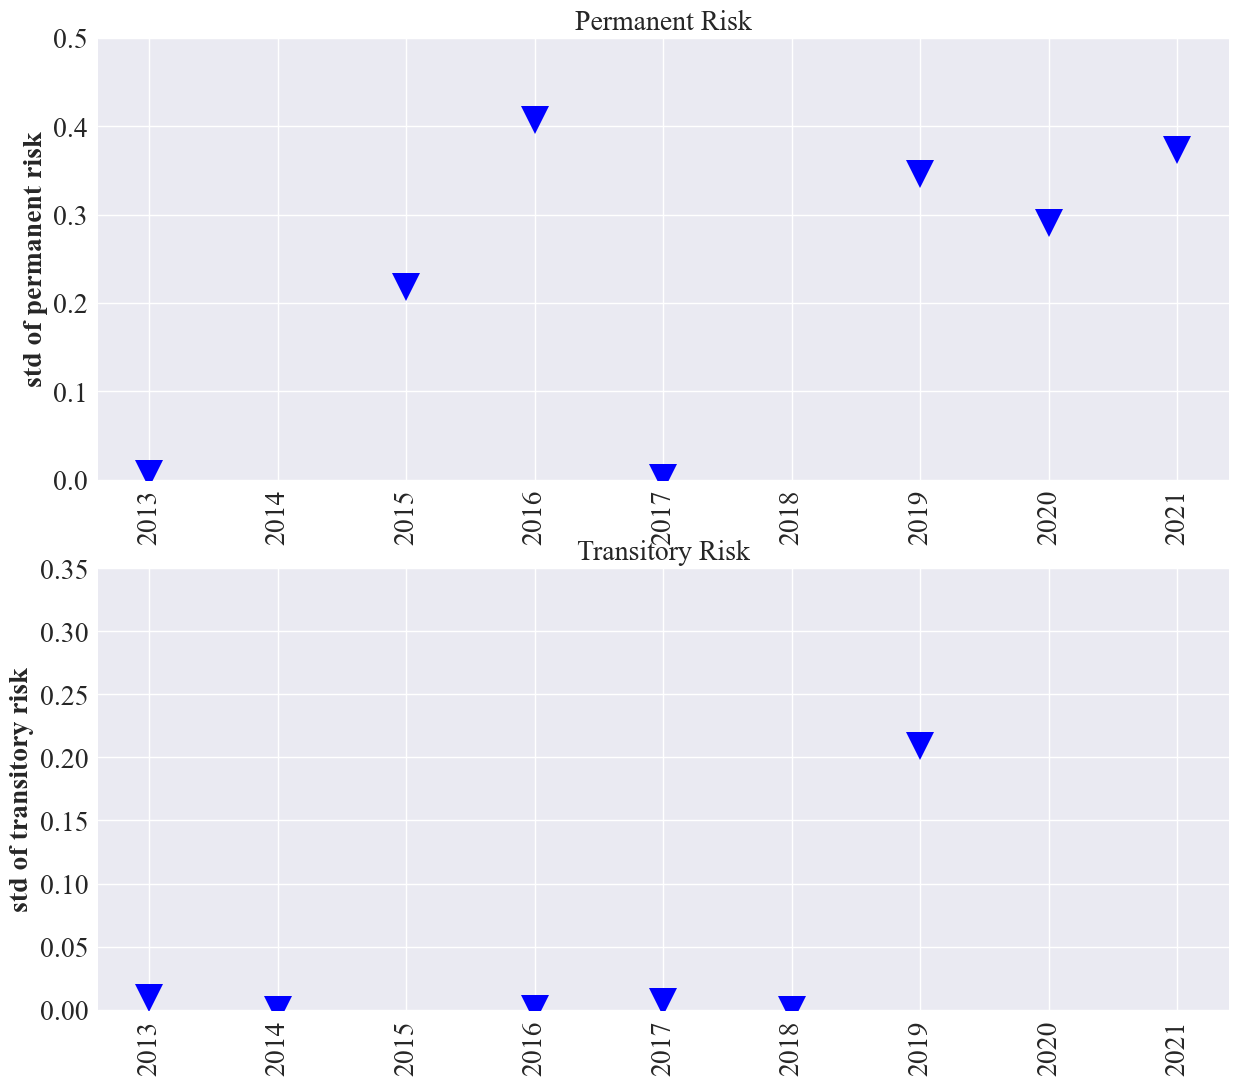

In [66]:
## plot estimate 

lw = 3
for i,paras_est in enumerate([data_para_est_full]):
    print('whole sample')
    fig = plt.figure(figsize=([13,12]))
    this_est = paras_est
    p_risk = abs(this_est[1][0][1:])
    p_risk[p_risk<1e-5]= np.nan ## replace non-identified with nan
    print('Average permanent risk (std): ',str(np.nanmean(np.sqrt(p_risk))))
    t_risk = abs(this_est[1][1][1:])
    t_risk[t_risk<1e-5]= np.nan ## replace non-identified with nan
    print('Average transitory risk (std): ',str(np.nanmean(np.sqrt(t_risk))))
    plt.subplot(2,1,1)
    plt.title('Permanent Risk')
    plt.plot(years,
             p_risk,
             'bv',
             markersize=20,
             label='Estimation')
    plt.ylim(0.0,0.5)
    plt.ylabel('std of permanent risk')
    plt.xticks(years,
               rotation='vertical')
    plt.grid(True)

    plt.subplot(2,1,2)
    plt.title('Transitory Risk')
    plt.plot(years,
             t_risk,
             'bv',
             markersize=20,
             label='Estimation')
    plt.xticks(years,
               rotation='vertical')
    plt.ylim(0.0,0.35)
    plt.ylabel('std of transitory risk')
    #plt.legend(loc=0)
    plt.grid(True)
    plt.savefig('../Graphs/sipp/permanent-transitory-risk-yearly.jpg')

### Estimation using SIPP data (quarterly)



In [12]:
## SIPP data 
SIPP_Q = pd.read_stata('../../../SIPP/sipp_matrix_Q.dta',
                    convert_categoricals=False)   
SIPP_Q.index = SIPP_Q['uniqueid']
SIPP_Q = SIPP_Q.drop(['uniqueid'], axis=1)
SIPP_Q = SIPP_Q.dropna(axis=0,how='all')

In [13]:
## different samples 

education_groups = [1, #'HS dropout',
                   2, # 'HS graduate',
                   3] #'college graduates/above'
gender_groups = [1, #'male',
                2] #'female'

#byear_groups = list(np.array(SIPP.byear_5yr.unique(),dtype='int32'))

age_groups = list(np.array(SIPP_Q.age_5yr.unique(),dtype='int32'))

group_by = ['educ','gender','age_5yr']
all_drop = group_by #+['age_h','byear_5yr']

## full sample 
sample_full =  SIPP_Q.drop(all_drop,axis=1)

## sub sample 
sub_samples = []
para_est_list = []
sub_group_names = []

for edu in education_groups:
    for gender in gender_groups:
        for age5 in age_groups:
            belong = (SIPP_Q['educ']==edu) & (SIPP_Q['gender']==gender) & (SIPP_Q['age_5yr']==age5)
            obs = np.sum(belong)
            #print(obs)
            if obs > 1:
                sample = SIPP_Q.loc[belong].drop(all_drop,axis=1)
                sub_samples.append(sample)
                sub_group_names.append((edu,gender,age5))

C:\Users\want\AppData\Local\Temp\ipykernel_5824\3929378100.py:11: RuntimeWarning: invalid value encountered in cast
  age_groups = list(np.array(SIPP_Q.age_5yr.unique(),dtype='int32'))


In [14]:
## estimation for full sample 

data_para_est_full = estimate_sample(sample_full)

## time stamp 
quarter_str = [string.replace('lwage_Q_id_shk_gr','') for string in sample_full.columns if 'lwage_Q_id_shk_gr' in string]
quarter_str = [qst[:4]+'Q'+qst[4:] for qst in quarter_str]
quarters = np.array(quarter_str) 

C:\Users\want\AppData\Local\Temp\ipykernel_5824\1300134485.py:9: RuntimeWarning: Mean of empty slice
  data_mean = np.nanmean(data,axis=0)


Optimization terminated successfully.
         Current function value: 0.177780
         Iterations: 71
         Function evaluations: 5548
         Gradient evaluations: 73


whole sample


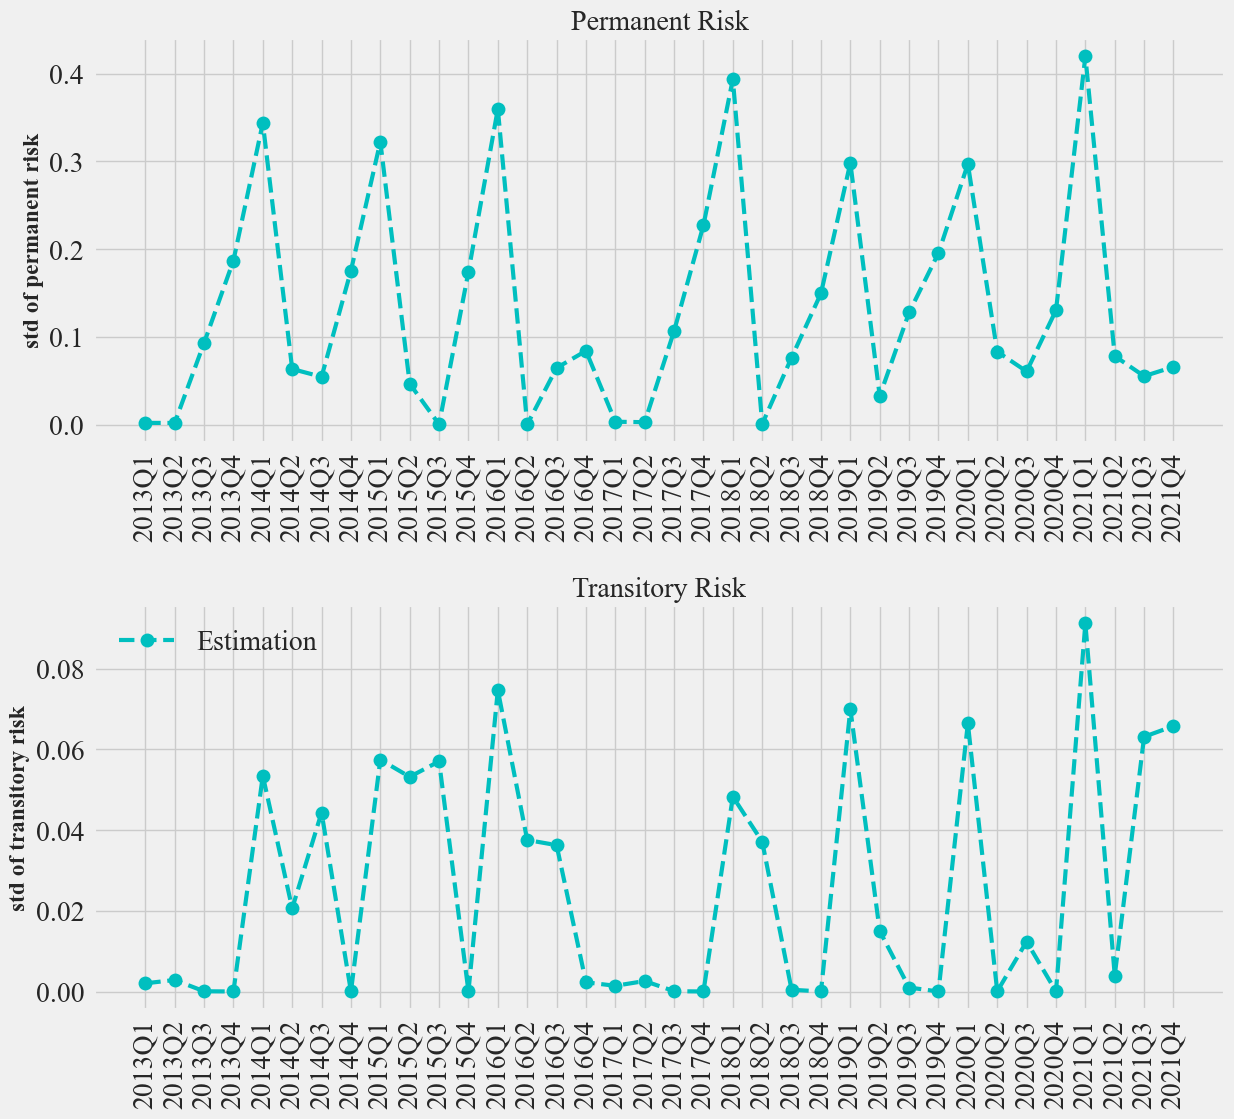

In [15]:
## plot estimate 

lw = 3
for i,paras_est in enumerate([data_para_est_full]):
    print('whole sample')
    fig = plt.figure(figsize=([13,12]))
    this_est = paras_est
    p_risk = abs(this_est[1][0][1:])
    t_risk = abs(this_est[1][1][1:])
    p_risk[p_risk<1e-6]= np.nan
    t_risk[t_risk<1e-6]= np.nan
    plt.subplot(2,1,1)
    plt.title('Permanent Risk')
    plt.plot(quarters,
             p_risk,
             'c--o',
             markersize=10,
             #markerfacecolor='none',
             lw=lw,
             label='Estimation')
    plt.ylabel('std of permanent risk')
    plt.xticks(quarters,
               rotation='vertical')
    plt.grid(True)

    plt.subplot(2,1,2)
    plt.title('Transitory Risk')
    plt.plot(quarters,
             t_risk, 
             'c--o',
             markersize=10,
             #markerfacecolor='none',
             lw=lw,
             label='Estimation')
    plt.xticks(quarters,
               rotation='vertical')
    plt.ylabel('std of transitory risk')
    plt.legend(loc=0)
    plt.grid(True)
    plt.subplots_adjust(
                    #left=0.1,
                    #bottom=0.1, 
                    #right=0.9, 
                   # top=0.9, 
                    #wspace=0.4, 
                    hspace=0.4)
    plt.savefig('../Graphs/sipp/permanent-transitory-risk-quarterly.jpg')

### Estimation using SIPP data (monthly)

In [16]:
## SIPP data 
SIPP = pd.read_stata('../../../SIPP/sipp_matrix.dta',
                    convert_categoricals=False)   
SIPP.index = SIPP['uniqueid']
SIPP = SIPP.drop(['uniqueid'], axis=1)
SIPP = SIPP.dropna(axis=0,how='all')
#SIPP = SIPP.dropna(axis=1,how='all')

#SIPP=SIPP.dropna(subset=['byear_5yr'])
#SIPP['byear_5yr'] = SIPP['byear_5yr'].astype('int32')

In [17]:
SIPP.columns

Index(['gender', 'educ', 'age_5yr', 'lwage_id_shk_gr201303',
       'lwage_id_shk_gr201304', 'lwage_id_shk_gr201305',
       'lwage_id_shk_gr201306', 'lwage_id_shk_gr201307',
       'lwage_id_shk_gr201308', 'lwage_id_shk_gr201309',
       ...
       'lwage_id_shk_gr202103', 'lwage_id_shk_gr202104',
       'lwage_id_shk_gr202105', 'lwage_id_shk_gr202106',
       'lwage_id_shk_gr202107', 'lwage_id_shk_gr202108',
       'lwage_id_shk_gr202109', 'lwage_id_shk_gr202110',
       'lwage_id_shk_gr202111', 'lwage_id_shk_gr202112'],
      dtype='object', length=109)

In [18]:
SIPP.dtypes

gender                   float32
educ                     float32
age_5yr                  float32
lwage_id_shk_gr201303    float32
lwage_id_shk_gr201304    float32
                          ...   
lwage_id_shk_gr202108    float32
lwage_id_shk_gr202109    float32
lwage_id_shk_gr202110    float32
lwage_id_shk_gr202111    float32
lwage_id_shk_gr202112    float32
Length: 109, dtype: object

In [19]:
## different samples 

education_groups = [1, #'HS dropout',
                   2, # 'HS graduate',
                   3] #'college graduates/above'
gender_groups = [1, #'male',
                2] #'female'

#byear_groups = list(np.array(SIPP.byear_5yr.unique(),dtype='int32'))

age_groups = list(np.array(SIPP.age_5yr.unique(),dtype='int32'))

group_by = ['educ','gender','age_5yr']
all_drop = group_by #+['age_h','byear_5yr']

## full sample 
sample_full =  SIPP.drop(all_drop,axis=1)

## sub sample 
sub_samples = []
para_est_list = []
sub_group_names = []

for edu in education_groups:
    for gender in gender_groups:
        for age5 in age_groups:
            belong = (SIPP['educ']==edu) & (SIPP['gender']==gender) & (SIPP['age_5yr']==age5)
            obs = np.sum(belong)
            #print(obs)
            if obs > 1:
                sample = SIPP.loc[belong].drop(all_drop,axis=1)
                sub_samples.append(sample)
                sub_group_names.append((edu,gender,age5))

C:\Users\want\AppData\Local\Temp\ipykernel_5824\3185638613.py:11: RuntimeWarning: invalid value encountered in cast
  age_groups = list(np.array(SIPP.age_5yr.unique(),dtype='int32'))


In [20]:
## estimation for full sample 

data_para_est_full = estimate_sample(sample_full)

C:\Users\want\AppData\Local\Temp\ipykernel_5824\1300134485.py:9: RuntimeWarning: Mean of empty slice
  data_mean = np.nanmean(data,axis=0)


Optimization terminated successfully.
         Current function value: 0.038817
         Iterations: 66
         Function evaluations: 15336
         Gradient evaluations: 71


In [21]:
## time stamp 
months_str = [string.replace('lwage_id_shk_gr','') for string in sample_full.columns if 'lwage_id_shk_gr' in string]
months = np.array(months_str)
#months_str2 = [mst[:4]+'M'+mst[4:] for mst in months_str]
#months2 = np.array(months_str2) # notice I dropped the first month 

whole sample


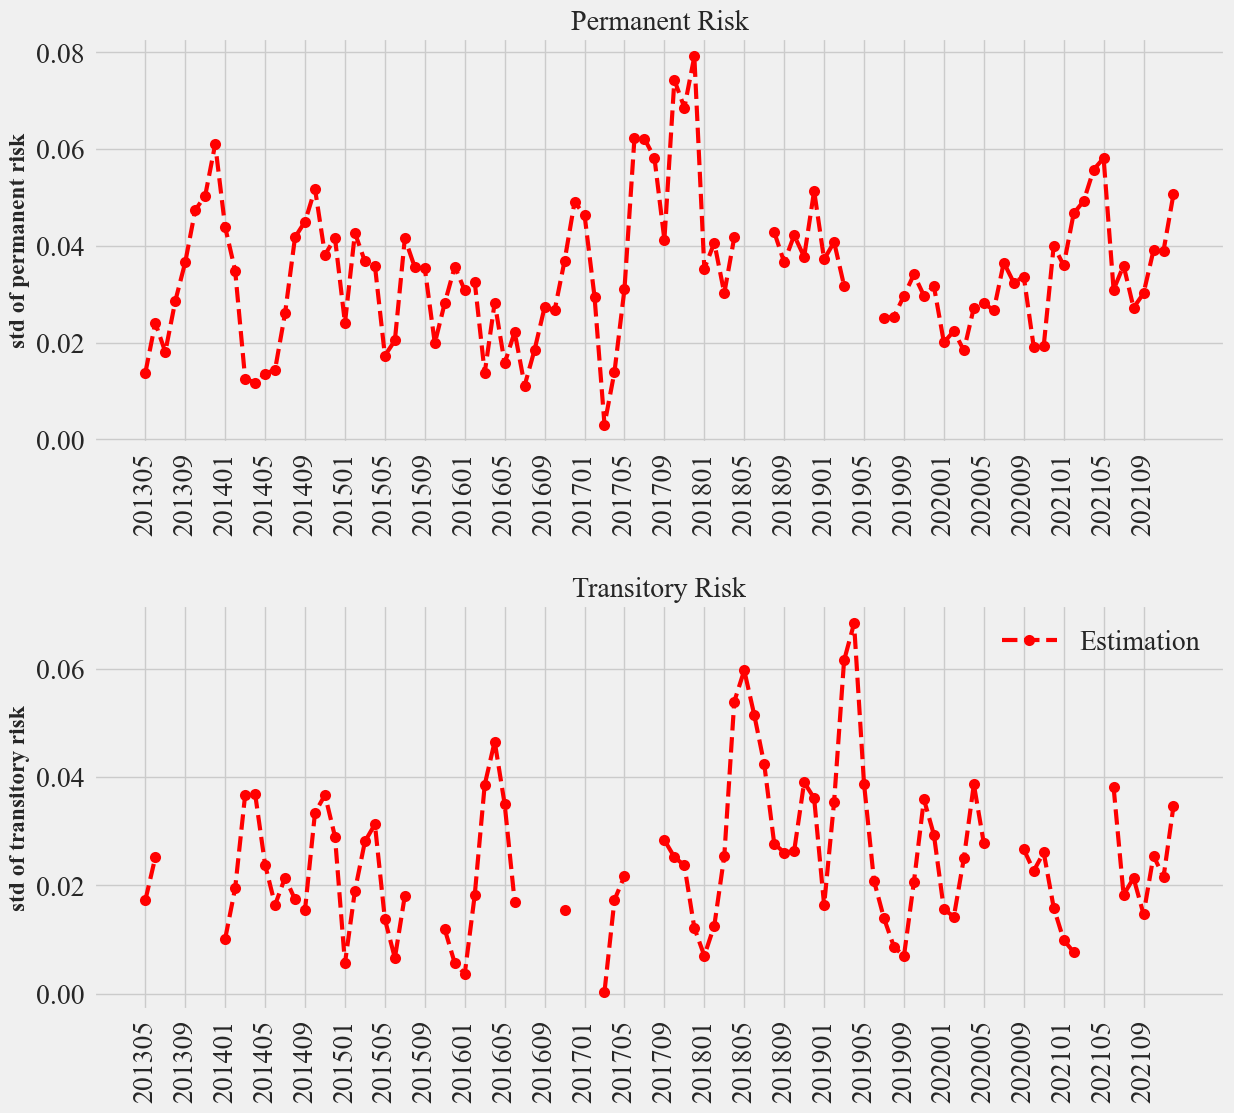

In [22]:
## plot estimate 

lw = 3
for i,paras_est in enumerate([data_para_est_full]):
    print('whole sample')
    fig = plt.figure(figsize=([13,12]))
    this_est = paras_est
    p_risk = abs(this_est[1][0][1:])
    t_risk = abs(this_est[1][1][1:])
    p_risk[p_risk<1e-4]= np.nan
    t_risk[t_risk<1e-4]= np.nan
    p_risk_mv = (p_risk[0:-2]+p_risk[1:-1]+p_risk[2:])/3
    t_risk_mv = (t_risk[0:-2]+t_risk[1:-1]+t_risk[2:])/3
    plt.subplot(2,1,1)
    plt.title('Permanent Risk')
    plt.plot(months[2:],
             p_risk_mv,
             'r--o',
             markersize=8,
             lw=lw,
             label='Estimation')
    plt.ylabel('std of permanent risk')
    plt.xticks(months[2::4],
               rotation='vertical')
    plt.grid(True)

    plt.subplot(2,1,2)
    plt.title('Transitory Risk')
    plt.plot(months[2:],
             t_risk_mv,
             'r--o',
             markersize=8,
             lw=lw,
             label='Estimation')
    plt.xticks(months[2::4],
               rotation='vertical')
    plt.ylabel('std of transitory risk')
    plt.legend(loc=0)
    plt.grid(True)
    plt.subplots_adjust(
                    #left=0.1,
                    #bottom=0.1, 
                    #right=0.9, 
                   # top=0.9, 
                    #wspace=0.4, 
                    hspace=0.4)
    plt.savefig('../Graphs/sipp/permanent-transitory-risk.jpg')

In [23]:
## generate a dataset of date, permanent and transitory 

est_df = pd.DataFrame()

#vols_est_sub_group = pd.DataFrame([])
for i,para_est in enumerate([data_para_est_full]):
    #print(i)
    #print(group_var)
    times = len(months)
    this_est = pd.DataFrame([list(months),
                             np.abs(para_est[1][0]), 
                             np.abs(para_est[1][1])] 
                           ).transpose()
    est_df = pd.concat([est_df,
                        this_est])
    
    
## post-processing
est_df.columns = ['YM','permanent','transitory']
est_df=est_df.dropna(how='any')
for var in ['YM']:
    est_df[var] = est_df[var].astype('int32')

est_df['permanent']= est_df['permanent'].astype('float')
est_df['transitory']=est_df['transitory'].astype('float')

In [24]:
## replace extreme values 
for date in [201303,201401,201501,201601,201701]:
    est_df.loc[est_df['YM']==date,'permanent']=np.nan
    
est_df

,YM,permanent,transitory
0,201303,NaN,0.000294
1,201304,0.000294,0.001465
2,201305,0.040364,0.050126
3,201306,0.000468,0.000123
4,201307,0.031429,0.025326
...,...,...,...
101,202108,0.037665,0.000690
102,202109,0.027844,0.022665
103,202110,0.024992,0.020775
104,202111,0.064436,0.033082


<AxesSubplot:>

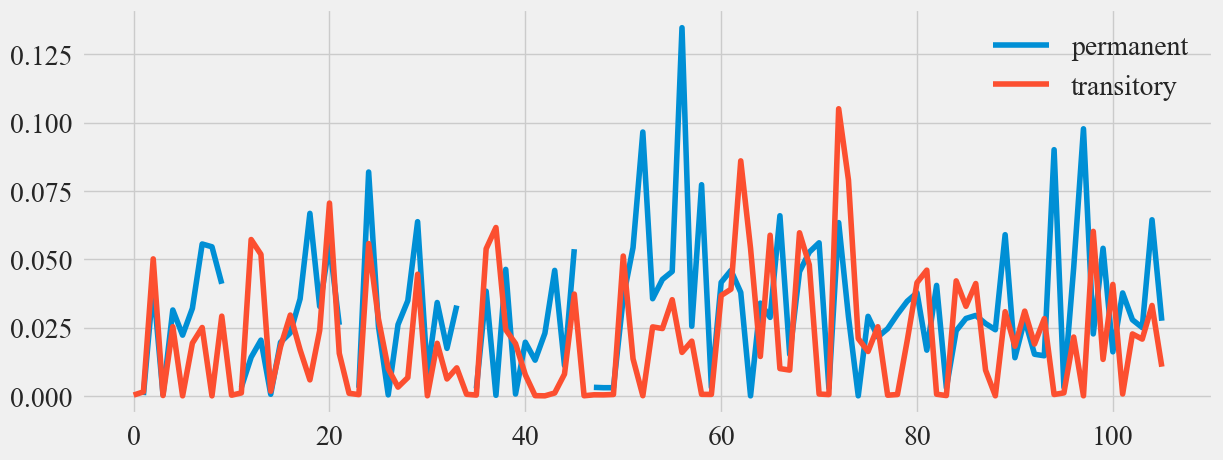

In [25]:
est_df[['permanent','transitory']].plot(figsize=(13,5))

In [26]:
## export to stata
est_df.to_stata('../OtherData/sipp/sipp_history_vol_decomposed.dta')

In [27]:
## estimation for sub-group

for sample in sub_samples:
    ## estimation
    data_para_est = estimate_sample(sample)
    para_est_list.append(data_para_est)

C:\Users\want\AppData\Local\Temp\ipykernel_5824\1300134485.py:9: RuntimeWarning: Mean of empty slice
  data_mean = np.nanmean(data,axis=0)


Optimization terminated successfully.
         Current function value: 0.067084
         Iterations: 102
         Function evaluations: 23112
         Gradient evaluations: 107
Optimization terminated successfully.
         Current function value: 0.067831
         Iterations: 96
         Function evaluations: 21168
         Gradient evaluations: 98
Optimization terminated successfully.
         Current function value: 0.014409
         Iterations: 62
         Function evaluations: 14256
         Gradient evaluations: 66
Optimization terminated successfully.
         Current function value: 0.010042
         Iterations: 67
         Function evaluations: 15552
         Gradient evaluations: 72
Optimization terminated successfully.
         Current function value: 0.010337
         Iterations: 67
         Function evaluations: 14904
         Gradient evaluations: 69
Optimization terminated successfully.
         Current function value: 0.079558
         Iterations: 79
         Function e

Optimization terminated successfully.
         Current function value: 0.269400
         Iterations: 117
         Function evaluations: 25704
         Gradient evaluations: 119


In [28]:
## generate a dataset of year, edu, gender, byear_5yr permanent and transitory 

est_df = pd.DataFrame()

#vols_est_sub_group = pd.DataFrame([])
for i,para_est in enumerate(para_est_list):
    #print(i)
    group_var = sub_group_names[i]
    #print(group_var)
    times = len(months)
    this_est = pd.DataFrame([[group_var[0]]*times,   ##educ
                             [group_var[1]]*times,   ## gender 
                             [group_var[2]]*times,   ## age_5yr
                             list(months),
                             np.abs(para_est[1][0]), 
                             np.abs(para_est[1][1])] 
                           ).transpose()
    est_df = pd.concat([est_df,
                         this_est])

In [29]:
## post-processing
est_df.columns = group_by+['YM','permanent','transitory']
est_df=est_df.dropna(how='any')
for var in group_by+['YM']:
    est_df[var] = est_df[var].astype('int32')
    

est_df['permanent']=est_df['permanent'].astype('float')
est_df['transitory']=est_df['transitory'].astype('float')

In [30]:
for date in [201303,201401,201501,201601,201701]:
    est_df.loc[est_df['YM']==date,'permanent']=np.nan

In [31]:
## export to stata
est_df.to_stata('../OtherData/sipp/sipp_history_vol_decomposed_edu_gender_age5.dta')

In [32]:
est_df.head()

,educ,gender,age_5yr,YM,permanent,transitory
0,1,1,45,201303,NaN,0.001260
1,1,1,45,201304,0.001260,0.001308
2,1,1,45,201305,0.003556,0.007276
3,1,1,45,201306,0.000638,0.006361
4,1,1,45,201307,0.000666,0.007330
